In [23]:
%load_ext jupyternotify

import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
from scipy.constants import e, k, h
from scipy.interpolate import interp1d
import itertools
import numba
from numba import jit
from numba.core import types
from numba.typed import Dict
from scipy.optimize import minimize, basinhopping
rok_energy = 1e-3*e
Delta = 0.166*1e-3*e

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [24]:
@jit(nopython=True)
def gamma(g0, v0, T, N):
    numerator = np.exp(v0/(k*T)) + N
    denominator = np.exp(v0/(k*T)) - 1
    return g0*numerator/denominator

@jit(nopython=True)
def etta(g0, v0, T, N):
    numerator = N*gamma(g0, v0, T, N)
    denominator = 4*k*T*((np.cosh(v0/(2*k*T)))**2)
    return numerator/denominator

@jit(nopython=True)
def llambda(v0, T, N):
    numerator = np.exp(v0/(k*T)) + 1
    denominator = np.exp(v0/(k*T)) + N
    return numerator/denominator
    

In [25]:
@jit(nopython=True)
def p0(smg, T, N):
    numerator = np.exp(smg/(k*T))
    denominator = np.exp(smg/(k*T)) + N
    return numerator/denominator

@jit(nopython=True)
def q_capacitance(smg, T, N, dne, dng):
    return (e**2) * (p0(smg, T, N)*(dng - dne) + dne)

@jit(nopython=True)
def tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ng - ne)*gamma(g0, smg, T, N)
    denominator = gamma(g0, smg, T, N)**2 + w**2
    return numerator/denominator

@jit(nopython=True)
def total_capacitance(g0, smg, dsmg, T, N, ne, ng, dne, dng, w):
    return tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w) + q_capacitance(smg, T, N, dne, dng)

@jit(nopython=True)
def I_resistance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ng - ne)*(w**2)
    denominator = gamma(g0, smg, T, N)**2 + w**2
    return numerator/denominator

In [26]:
dirpath = f"f1web.ijs.si\\~zitko\\data\\chi\\"
Uset = tuple(np.sort([float(file_names[2:]) for file_names in os.listdir(dirpath) if file_names[0:2]=='U=']))

Gamma_dict = tuple([np.array([file_names.split('=')[-1]
                         for file_names in os.listdir(dirpath+f'U={Uvals}')
                         if file_names[0:2]=='U=']) for Uvals in Uset])

@jit(nopython=True)
def Gamma_dict_func(U):
    for idx, Uvals in enumerate(Uset):
        if Uvals==U:
            return Gamma_dict[idx]

In [27]:
optical1_data = tuple([np.array(
    [
        np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\optical1.dat")[:400]
        for gammaa in Gamma_dict_func(Uvals)
    ]) for Uvals in Uset])

n1_data = tuple([np.array(
    [
        np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n1.dat")[:400]
        for gammaa in Gamma_dict_func(Uvals)
    ]) for Uvals in Uset])

n2_data = tuple([np.array(
    [
        np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n2.dat")[:400]
        for gammaa in Gamma_dict_func(Uvals)
    ]) for Uvals in Uset])


In [28]:
@jit(nopython=True)
def optical_func(U,gamma):
    gset = Gamma_dict_func(U)
    for idx in range(len(gset)):
        if gset[idx]==gamma:
            return optical1_data[Uset.index(U)][idx,:,:]

@jit(nopython=True)
def n1_func(U,gamma):
    gset = Gamma_dict_func(U)
    for idx in range(len(gset)):
        if gset[idx]==gamma:
            return n1_data[Uset.index(U)][idx,:,:]
        
@jit(nopython=True)
def n2_func(U,gamma):
    gset = Gamma_dict_func(U)
    for idx in range(len(gset)):
        if gset[idx]==gamma:
            return n2_data[Uset.index(U)][idx,:,:]
        
@jit(nopython=True)
def rok_data_func(U,gamma):
    gset = Gamma_dict_func(U)
    for idx in range(len(gset)):
        if gset[idx]==gamma:
            return optical1_data[Uset.index(U)][idx,:,:], n1_data[Uset.index(U)][idx,:,:], n2_data[Uset.index(U)][idx,:,:]
        

In [29]:
path = "G:\\My Drive\\GROWTH\\Quantum computing\\Majorana Project\\Experimental data\\data-oct4-21-mail-filip\\data\\"
dset_list2 = np.array(["01","02","03","04","05", "06", "07", "08", "09", "10"])
dataset_data2 = np.array(
    [
        np.loadtxt(
            f"{path}dataset_opening_{dset}.csv",
            skiprows=1,
            delimiter=','
        )[:,[0,1,5]] for dset in dset_list2
    ]
)

In [30]:
@jit(nopython=True)
def dataset_capfunc(dset):
    for idx in range(len(dset_list2)):
        if dset_list2[idx]==dset:
            return dataset_data2[idx,:,0:2]

@jit(nopython=True)
def dataset_resfunc(dset):
    for idx in range(len(dset_list2)):
        if dset_list2[idx]==dset:
            return dataset_data2[idx,:,0:3:2]

In [31]:
@jit(nopython=True)
def expvals(dset,sym):
    rangeval = 0.605
    capset = dataset_capfunc(dset)
    resset = dataset_resfunc(dset)
    exp_caps = capset[:,1]
    exp_ires = 1/resset[:,1]
    vex = capset[:,0]*1e3
    
    filter_arry = (vex<(rangeval))*(-rangeval<vex)
    exp_caps = exp_caps[filter_arry]
    exp_ires = exp_ires[filter_arry]
    vex = vex[filter_arry]
    
    exp_caps = exp_caps*1e15
    exp_ires = np.abs(exp_ires)*1e8
    
    if sym:
        exp_caps = (exp_caps + exp_caps[::-1])/2
        exp_ires = (exp_ires + exp_ires[::-1])/2
    return vex, exp_caps, exp_ires


In [32]:
@jit(nopython=True)
def fitting_s2(gammaa,alpha,T,N,v0,U=0.333):
    v0 = v0*alpha
    nu = (1 - v0/U)
    
#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
    op1,n1,_ = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, 0, dn_g)*1e15
    
    return Q_Caps

@jit(nopython=True)
def fitting_s3(gammaa,alpha,T,N,v0,U=0.333):
    v0 = v0*alpha
    nu = (1 - v0/U)

#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
#     n2 = n2_func(U,gammaa)
    op1,n1,n2 = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    
    return Q_Caps

@jit(nopython=True)
def fitting_s4(gammaa,g0,alpha,T,N,v0,U=0.333):
    v0 = v0*alpha
    nu = (1 - v0/U)
    w = 2*np.pi*368*1e6

#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
#     n2 = n2_func(U,gammaa)
    op1,n1,n2 = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    n_g = np.interp(nu, n1[:,0], n1[:,1])
    n_e = np.interp(nu, n2[:,0], n2[:,1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    ds_mg = np.interp(nu, op1[1:,0], (op1[1:,1] - op1[:-1,1])/(-0.01*U))*Delta/rok_energy
    ds_mg = (ds_mg + ds_mg[::-1])/2
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    
    return Q_Caps + T_Caps

@jit(nopython=True)
def fitting_s5(gammaa,g0,alpha,T,N,v0,U=0.333):
    v0 = v0*alpha
    nu = (1 - v0/U)
    w = 2*np.pi*368*1e6

#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
#     n2 = n2_func(U,gammaa)
    op1,n1,n2 = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    n_g = np.interp(nu, n1[:,0], n1[:,1])
    n_e = np.interp(nu, n2[:,0], n2[:,1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    ds_mg = np.interp(nu, op1[1:,0], (op1[1:,1] - op1[:-1,1])/(-0.01*U))*Delta/rok_energy
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    C_total = Q_Caps + T_Caps
    
    Ires = -alpha*alpha*I_resistance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e8
    return C_total, Ires

In [33]:
@jit(nopython=True)
def fitting_s6(U,gammaa,g0,alpha,T,N,v0):
    v0 = v0*alpha
    nu = (1 - v0/U)
    w = 2*np.pi*368*1e6
    
#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
#     n2 = n2_func(U,gammaa)
    op1,n1,n2 = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    n_g = np.interp(nu, n1[:,0], n1[:,1])
    n_e = np.interp(nu, n2[:,0], n2[:,1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    ds_mg = np.interp(nu, op1[1:,0], (op1[1:,1] - op1[:-1,1])/(-0.01*U))*Delta/rok_energy
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    C_total = Q_Caps + T_Caps
    
    Ires = -alpha*alpha*I_resistance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e8
    return C_total, Ires

In [109]:
@jit(nopython=True)
def fitting_s7(U,gammaa,g0,alpha,T,N,v0):
    v0 = v0*alpha
    nu = (1 - v0/U)
    w = 2*np.pi*368*1e6
    
#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
#     n2 = n2_func(U,gammaa)
    op1,n1,n2 = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    n_g = np.interp(nu, n1[:,0], n1[:,1])
    n_e = np.interp(nu, n2[:,0], n2[:,1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    ds_mg = np.interp(nu, op1[1:,0], (op1[1:,1] - op1[:-1,1])/(-0.01*U))*Delta/rok_energy
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    C_total = Q_Caps + T_Caps
    
    Ires = -alpha*alpha*I_resistance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e8
    return C_total, Ires

# T_Caps = np.array([-alpha*alpha*tunnel_capacitance(g0vals, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15 for g0vals in g0])
# Ires = np.array([-alpha*alpha*I_resistance(g0vals, s_mg, ds_mg, T, N, n_e, n_g, w)*1e8 for g0vals in g0])

In [180]:
@jit(nopython=True)
def weight_s7(U,dset,gammaa,g0,alpha,T,N,sym):
    expV, expC, expIR = expvals(dset, sym)
    theoC, theoIR = fitting_s7(U,gammaa,g0,alpha,T,N,expV)
    weitC = ((theoC - expC)**2)/(np.maximum(0.027,(theoC + expC)/2)**2)*(1 - np.abs(expV)/0.6)
    weitIR = ((theoIR - expIR)**2)/(np.maximum(1,(theoIR + expIR)/2)**2)*(1 - np.abs(expV)/0.6)
    return np.sum(weitC)+np.sum(weitIR)

@jit(nopython=True)
def total_weight_s7(U,dset,g0,alpha,T,N,sym):
    gset = Gamma_dict_func(U)
    weightset = [weight_s7(U,dset,gama,g0, alpha,T,N,sym) for gama in gset]
    weightset = np.array(weightset)
    winweitidx = np.argmin(weightset)
    return gset[winweitidx], weightset[winweitidx]

@jit(nopython=True)
def total_set_weight_s7(params,sym,U):
    alpha,T,fac = params[10:]
    g0set = params[:10]
    dset_list = ["01","02","03","04","05", "06", "07", "08", "09", "10"]
    allweightset = np.array([total_weight_s7(U,dset_list[idx],10**g0set[idx],alpha,T/100,10**fac,sym)[1] for idx in range(len(dset_list))])
    totalweight = np.sum(allweightset)
    return totalweight
    
def fitplot_s7(dset,g0,alpha,T,N,sym,U):
    expV, expC, expIR = expvals(dset,sym)
    
    gamma, weit = total_weight_s7(U,dset,g0,alpha,T,N,sym)
    print(gamma, weit)
    TheoC, TheoIR = fitting_s7(U,gamma,g0,alpha,T,N,expV)
    
    fig, axes = plt.subplots(1,2)
    axes[0].plot(expV, expC)
    axes[0].plot(expV, TheoC)
    axes[1].plot(expV, expIR)
    axes[1].plot(expV, TheoIR)
    print(np.mean(np.abs(TheoIR)))

In [181]:
# total_set_weight_s7(( 8.0, 0.32, 6.0, 6.0),1,0.333)

# total_set_weight_s7((10.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 0.32, 6.0, 6.0),1,0.333)
total_set_weight_s7((*(np.random.random(10)+10*np.random.random(10)), 0.32, 6.0, 6.0),1,0.333)

# [*(np.random.random(10)+10*np.random.random(10)),2,3]

279.25335225353297

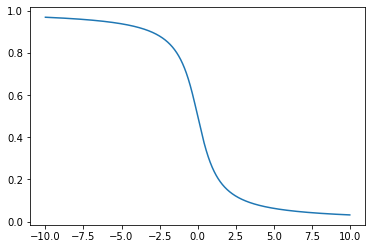

In [199]:
a = np.arange(-10,10,0.01)
plt.plot(a,1 - (0.5+0.5*np.arctan(a)/(np.pi/2)))

0.06000 39.13429156850518
1.1838294768726663


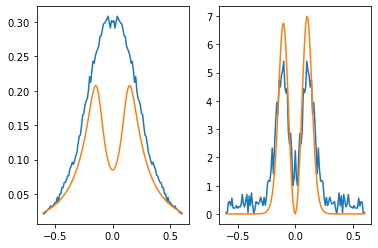

In [61]:
fitplot_s7('09', 10**8.0, 0.65, 10/100, 10**6.5, 1, 0.333)

In [68]:
total_set_weight_s7((8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 0.32, 6.0, 6.0),1,0.333)

238.32066592097325

In [87]:
def minimize_func(U):
    result_s7 = minimize(total_set_weight_s7, (8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 0.32, 6.0, 6.0),args=(1,U),method = 'trust-constr')
    return_set = [result_s7.success]
    if result_s7.success:
        return_set.append(result_s7.fun)
        return_set.append(result_s7.x)
    return return_set


In [89]:
%%time
bigres = []
for Uvals in Uset:
    setss = minimize_func(Uvals)
    print(setss)
    bigres.append(setss)

[True, 421.182004067551, array([6.66371895, 7.1421957 , 8.39099439, 8.03905831, 8.35065401,
       9.56834819, 9.30653638, 9.55443455, 9.30342379, 8.12375201,
       0.38965025, 8.87411478, 7.71233953])]
[True, 341.6082520916, array([6.41850259, 7.09471331, 7.38296799, 7.55096437, 8.14073025,
       8.86142569, 9.24392686, 9.48982606, 9.19526239, 8.21245032,
       0.53443301, 9.21413839, 9.04284303])]
[True, 339.41136680865793, array([6.72073576, 7.18960924, 8.28977938, 7.94544689, 8.22705232,
       9.58917172, 9.48452804, 9.70917944, 9.57861512, 8.56204738,
       0.42432212, 8.0772953 , 6.94207968])]
[True, 259.5727026943109, array([ 6.61634947,  7.05317684,  7.7252766 ,  7.54595017,  8.00909449,
        9.54429589,  9.08382024,  9.690145  ,  8.99925641,  8.54370941,
        0.56032655, 10.41561933,  5.40989493])]
[True, 254.44642342575372, array([ 6.70696654,  6.99872178,  7.34286289,  7.56919556,  8.0372862 ,
        9.7241122 ,  9.18392933,  9.60803763,  9.09682338,  8.39448893,

In [94]:
def minimize_funch(U):
    result_sh = basinhopping(total_set_weight_s7, (8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 0.32, 6.0, 6.0),
                      niter=30, minimizer_kwargs={'args':(1,U),"method": 'trust-constr'})#, T=10, stepsize=2)
    return_set = [result_sh.lowest_optimization_result.success]
    if result_sh.lowest_optimization_result.success:
        return_set.append(result_sh.lowest_optimization_result.fun)
        return_set.append(result_sh.lowest_optimization_result.x)
    return return_set


In [92]:
Uset

(0.166, 0.249, 0.333, 0.416, 0.5, 0.666, 1.0)

In [95]:
%%time
bigresh = []
for Uvals in Uset:
    setss = minimize_funch(Uvals)
    print(setss)
    bigresh.append(setss)

# 202111111146 (C:G = 1:1)
# # [True, 420.1565763241273, array([6.59689078, 7.06947097, 8.44784516, 7.911274  , 8.3397318 ,
# #        9.44679208, 9.29682013, 9.57894793, 9.2641769 , 8.09995387,
# #        0.39488162, 9.23251339, 7.42795569])]
# # [True, 337.2400342596625, array([6.47084167, 7.04490415, 7.54663439, 7.63873632, 8.04818039,
# #        9.41687057, 9.21504604, 9.58331686, 9.11286948, 8.85636891,
# #        0.50360787, 9.41954551, 8.23337082])]
# # [True, 284.8276581915461, array([ 6.52316709,  7.07214648,  7.4755468 ,  7.54289243,  7.98219701,
# #         8.73016133,  9.1972646 ,  9.60542762,  9.09552953, 10.18069997,
# #        -0.56243733,  9.44094754,  7.88934296])]
# # [True, 257.3617990053706, array([ 6.62451249,  7.01846287,  7.76878153,  7.50840089,  7.91398013,
# #         9.10867248,  9.11835344,  9.66288511,  9.03609659, 10.12308835,
# #         0.56647029, 11.08593312,  5.01164267])]
# # [True, 223.9449434138836, array([ 6.75532978,  7.04031695,  7.37116974,  7.65773489,  8.04236288,
# #         9.20834237,  9.19313668,  9.59108898,  9.11346367,  8.78932677,
# #         0.54513362, 11.80702742,  2.37405237])]
# # [True, 307.88993113243873, array([ 6.54325193,  6.88747314,  7.26193071,  7.49449888,  7.8924525 ,
# #         8.40908683,  8.7785438 ,  9.12051242,  8.92207484,  8.98587888,
# #         0.87092307, 15.05536113,  2.01908149])]
# # [True, 666.1863799105552, array([7.49478895, 7.73113601, 8.01847858, 7.93006303, 9.27928331,
# #        9.28573781, 9.23289678, 9.36958248, 9.18762664, 8.14627337,
# #        0.86859975, 5.08246088, 5.3211711 ])]
# # Wall time: 2h 3min 23s


[True, 420.1565763241273, array([6.59689078, 7.06947097, 8.44784516, 7.911274  , 8.3397318 ,
       9.44679208, 9.29682013, 9.57894793, 9.2641769 , 8.09995387,
       0.39488162, 9.23251339, 7.42795569])]
[True, 337.2400342596625, array([6.47084167, 7.04490415, 7.54663439, 7.63873632, 8.04818039,
       9.41687057, 9.21504604, 9.58331686, 9.11286948, 8.85636891,
       0.50360787, 9.41954551, 8.23337082])]
[True, 284.8276581915461, array([ 6.52316709,  7.07214648,  7.4755468 ,  7.54289243,  7.98219701,
        8.73016133,  9.1972646 ,  9.60542762,  9.09552953, 10.18069997,
       -0.56243733,  9.44094754,  7.88934296])]
[True, 257.3617990053706, array([ 6.62451249,  7.01846287,  7.76878153,  7.50840089,  7.91398013,
        9.10867248,  9.11835344,  9.66288511,  9.03609659, 10.12308835,
        0.56647029, 11.08593312,  5.01164267])]
[True, 223.9449434138836, array([ 6.75532978,  7.04031695,  7.37116974,  7.65773489,  8.04236288,
        9.20834237,  9.19313668,  9.59108898,  9.1134636

In [177]:
min_idx = 3#np.argmin([bigreshvals[1] for bigreshvals in bigresh])
print('U =',Uset[min_idx])
print('Optvalues :',bigresh[min_idx][2])

U = 0.416
Optvalues : [ 6.62451249  7.01846287  7.76878153  7.50840089  7.91398013  9.10867248
  9.11835344  9.66288511  9.03609659 10.12308835  0.56647029 11.08593312
  5.01164267]


In [176]:
bigresh[min_idx][2][-2]

11.08593312406569

In [ ]:
fitting_s7(0.416,gamma,10**g0fac,alpha,T/100,10**fac,expV)

In [178]:
def gridplotfit_v4(res_list,sym,U,save=False):
    plt.close()
    *_,alpha,T,fac = res_list
    *g0set, _, _, _ = res_list
    dset_list = dset_list2
    allweightset = [total_weight_s7(U,dset_list[idx],10**g0set[idx],alpha,T/100,10**fac,sym)[0] for idx in range(len(dset_list))]
    scale = 4
    fig, (axes1, axes2, axes3, axes4, axes5, axes6) = plt.subplots(6,9,figsize=(9.5*scale,6*scale))

    for gamma, dset,g0fac,axis1,axis2,axis3,axis4,axis5,axis6 in zip(allweightset,dset_list,g0set,axes1,axes2,axes3,axes4,axes5,axes6):
        expV, expC, expIR = expvals(dset, sym)
        theoC, theoIR = fitting_s7(U,gamma,10**g0fac,alpha,T/100,10**fac,expV)
        
        axis1.text(0.35,1.1,f'$log_{{10}} \\Gamma^0 = {g0fac:.3f}$',transform=axis1.transAxes)
        axis1.plot(expV, expC,label=f'data set = {dset}')
        axis1.plot(expV, theoC,label=f'$\Gamma_t = ${gamma}')
        axis1.legend()
        axis1.set_ylim(0.0,None)
        
        axis2.plot(expV, expIR,label=f'data set = {dset}')
        axis2.plot(expV, theoIR,label=f'$\Gamma_t = ${gamma}')
        axis2.legend()
#         axis1.set_ylim(0.0,None)
        
        v0 = expV*alpha
        nu = (1 - (v0/U))
        op1 = optical_func(U,gamma)
        s_mg = np.interp(nu, op1[:,0], op1[:,1])
        axis3.plot(expV, s_mg,label=f'$\Gamma_t = ${gamma}')
#         axis2.legend()
        axis3.set_ylim(0.0,2.05)
        
        n1 = n1_func(U,gamma)
        n2 = n2_func(U,gamma)
        n_g = np.interp(nu, n1[:,0], n1[:,1])
        n_e = np.interp(nu, n2[:,0], n2[:,1])

        axis4.plot(expV, n_g,label=f'$n_g$')
        axis4.plot(expV, n_e,label=f'$n_e$')
        axis4.legend()
        axis4.set_ylim(0.0,2.1)
        
        C_tot, _ = fitting_s7(U,gamma,10**g0fac,alpha,T/100,10**fac,expV)
        C_qn = fitting_s3(gamma,alpha,T/100,10**fac,expV,U=U)
        C_q0 = fitting_s2(gamma,alpha,T/100,10**fac,expV,U=U)
        
        P0g = p0(s_mg*Delta, T/100, 10**fac)
        axis5.plot(expV,P0g,label=f'$\Gamma_t = ${gamma}')
        axis5.legend()
        
        axis6.plot(expV,C_tot,'k',label=r'$C_{total}$')
        axis6.plot(expV,C_q0,'--',label=r'$C_{q,g}$')
        axis6.plot(expV,C_qn - C_q0,'--',label=r'$C_{q,e}$')
        axis6.plot(expV,C_tot - C_qn,'--',label=r'$C_t$')
        axis6.legend()
        axis6.set_ylim(0.0,None)

    axes1[0].set_ylabel(r'Capacitance, C (fF)',fontsize=15)
    axes2[0].set_ylabel(r'Conductance, S ($10^{-8} \Omega^{-1}$)',fontsize=15)
    axes3[0].set_ylabel(r'Shiba mini-gap, $\delta / \Delta $',fontsize=15)
    axes4[0].set_ylabel(r'Occupation, $n$',fontsize=15)
    axes5[0].set_ylabel(r'P_{g,0}',fontsize=15)
    axes6[0].set_ylabel('Capacitance, C (fF)',fontsize=15)
    
    axes6[4].set_xlabel(r'$V_{P0} (mV) $',fontsize=20)
    
         
    parameter_string = f"$T = {T*10:.3f} mK $\
            $\\alpha        = {alpha:.3f} $\
            $U       = {U:.3f} $\
            $log_{{10}} N   = {fac:.3f}$"
    
    fig.text(
        0.5, 0.95, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=20)
    if sym:
        fig.text(
        0.5, 0.902, f"Stage 7 (Symmetrized) TW = {total_set_weight_s7(res_list,sym,U):.1f}", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)

    if save:
        res_list2 = res_list
        res_list2[-2] = res_list2[-2]*10
        if sym:
            plt.savefig(f"2D_grid_sym_S7_U{U}_log10_Go-{np.mean(res_list[:10]):.2f}_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['alpha-','mK_T-','log10_N-'],res_list2[10:])]}.pdf", format='pdf')
        else:
            plt.savefig(f"2D grid Not-sym S6 {[f'{member[0]}{member[1]:.2f}' for member in zip(['g0','a','T','N'],res_list)]}.pdf", format='pdf')
      

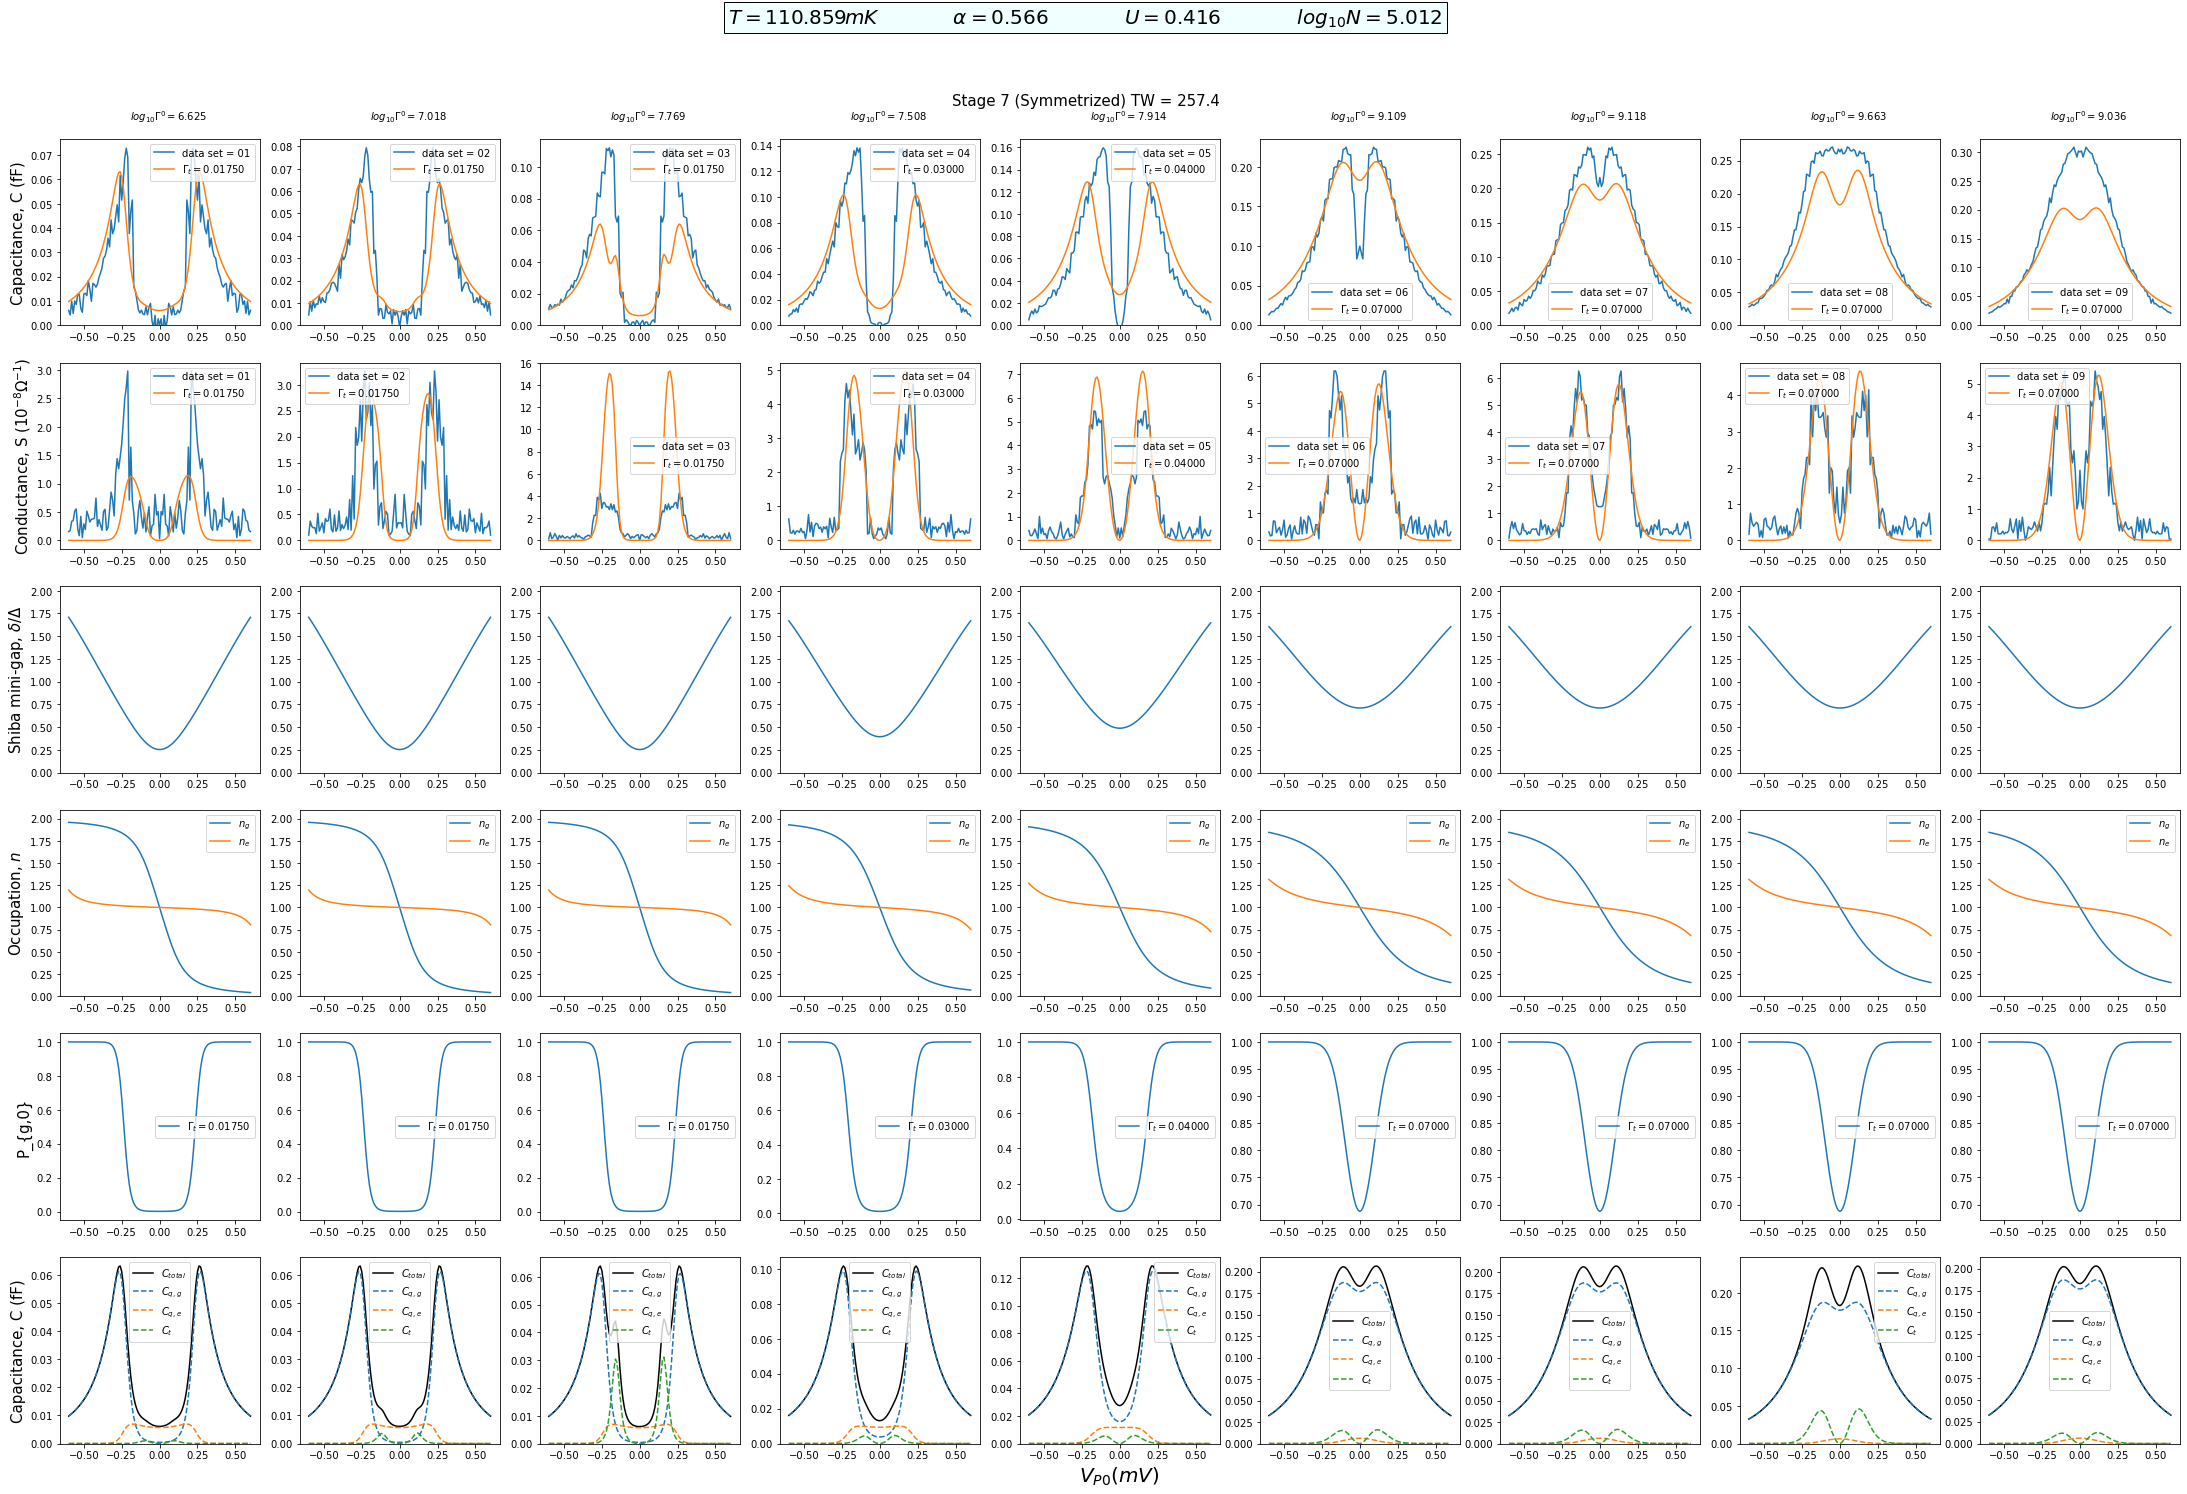

In [179]:
min_idx = 3
gridplotfit_v4(bigresh[min_idx][2],1,Uset[min_idx],True)

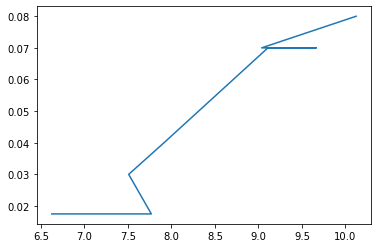

In [138]:
*_,alpha,T,fac = bigresh[min_idx][2]
*g0set, _, _, _ = bigresh[min_idx][2]
allweightset = [float(total_weight_s7(Uset[min_idx],dset_list2[idx],10**g0set[idx],alpha,T/100,10**fac,1)[0]) for idx in range(len(dset_list2))]

plt.plot(g0set,allweightset)

In [165]:
bigresh[min_idx][2][-2]

11.08593312406569

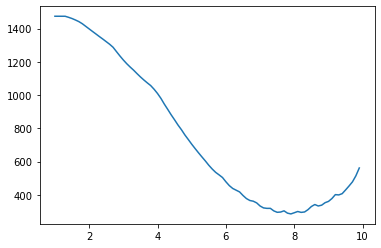

In [157]:
min_idx = 2
trial_vals = np.arange(1,10,0.1)
weiths = [total_set_weight_s7((*bigresh[min_idx][2][:-1],trial_valsss),1,Uset[min_idx]) for trial_valsss in trial_vals]
plt.plot(trial_vals,weiths)


In [151]:
(*bigresh[min_idx][2][:-1],trial_vals)

(6.755329780575654,
 7.040316954486755,
 7.371169737169117,
 7.6577348880601495,
 8.042362877942958,
 9.208342366169111,
 9.19313668383756,
 9.591088975344377,
 9.113463674864963,
 8.78932677404745,
 0.5451336205813054,
 11.807027418673492,
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
        2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
        3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
        4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1,
        6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4,
        7.5, 7.6, 7.7, 7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7,
        8.8, 8.9, 9. , 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]))

In [141]:
*_,alpha,T,fac = bigresh[min_idx][2]
*g0set, _, _, _ = bigresh[min_idx][2]

In [146]:
len(bigresh[min_idx][2][:-1])

12

In [ ]:
# # RENAME CODE

# For U Dirs
# # # for file_names in os.listdir(dirpath):
# # #     if file_names[0:2]=='U=':
# # #         os.rename(dirpath+file_names,dirpath+f'{file_names[:4]}{int(file_names[4:]):<03d}')

# For Gt dirs
# # # dirpath = f"f1web.ijs.si\\~zitko\\data\\chi\\"
# # # Uset = tuple(np.sort([file_names[2:] for file_names in os.listdir(dirpath) if file_names[0:2]=='U=']))

# # # Gamma_dict = list([list([file_names.split('=')[-1]
# # #                          for file_names in os.listdir(dirpath+f'U={Uvals}')
# # #                          if file_names[0:2]=='U=']) for Uvals in Uset])
# # # for idx1, usets in enumerate(Gamma_dict):
# # #     for idx2, gammavals in enumerate(usets):
# # #         filepath = f"U={Uset[idx1]}\\U={Uset[idx1]}_Gamma="
# # #         oldpath = dirpath+filepath+gammavals
# # #         newpath = dirpath+filepath + f'{gammavals[:-1]}{int(gammavals[-1]):<010d}'[:7]
# # #         os.rename(oldpath,newpath)


In [ ]:
# dirpath = f"f1web.ijs.si\\~zitko\\data\\chi\\"
# # Uset = list(np.sort([file_names[2:] for file_names in os.listdir(dirpath) if file_names[0:2]=='U=']))

# # Gamma_dict = {} #Dict.empty(key_type = types.unicode_type, value_type = types.float64[:])
# optical1_data = Dict.empty(key_type = types.unicode_type, value_type = types.float64[:,:,:])
# # n1_data = Dict.empty(key_type = types.unicode_type, value_type = types.float64[:,:,:])
# # n2_data = Dict.empty(key_type = types.unicode_type, value_type = types.float64[:,:,:])

# # for Uvals in Uset:
# #     Gamma_dict(Uvals) = np.array([file_names.split('=')[-1]
# #                          for file_names in os.listdir(dirpath+f'U={Uvals}')
# #                          if file_names[0:2]=='U='])
    
# # Gamma_dict['1.0'].remove('0.005') # this data file is incomplete

# for Uvals in Uset:
#     optical1_data[Uvals] = np.array(
#         [
#             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\optical1.dat")[:400]
#             for gammaa in Gamma_dict_func(Uvals)
#         ]
#     )
# #     n1_data[Uvals] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n1.dat")[:400]
# #             for gammaa in Gamma_dict[Uvals]
# #         ]
# #     )
# #     n2_data[Uvals] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n2.dat")[:400]
# #             for gammaa in Gamma_dict[Uvals]
# #         ]
# #     )

# # n1_data       = {Uvals:np.array([np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n1.dat")[:400] 
# #                                  for gammaa in Gamma_dict[Uvals]]) 
# #                  for Uvals in Uset}
# # n2_data       = {Uvals:np.array([np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n2.dat")[:400] 
# #                                  for gammaa in Gamma_dict[Uvals]]) 
# #                  for Uvals in Uset}

In [ ]:
# 
# # Udtype = np.dtype([(f'U{Uvals}', np.float64, (len(Gamma_dict_func(Uvals)),400)) for Uvals in Uset])
# # optical1_data = np.zeros(2,dtype=Udtype)
# # n1_data = np.zeros(2,dtype=Udtype)
# # n2_data = np.zeros(2,dtype=Udtype)

# # for Uvals in Uset:
# #     optical1_data[f'U{Uvals}'][0,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\optical1.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,0]
# #     optical1_data[f'U{Uvals}'][1,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\optical1.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,1]
    
# #     n1_data[f'U{Uvals}'][0,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n1.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,0]
# #     n1_data[f'U{Uvals}'][1,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n1.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,1]
    
# #     n2_data[f'U{Uvals}'][0,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n2.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,0]
# #     n2_data[f'U{Uvals}'][1,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n2.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,1]